In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [1]:
from tqdm import tqdm
import gc
from copy import deepcopy
from environment.gym_quadrotor import DroneEnv

import torch
import numpy as np
from torch import nn
import math
from models import *   
from train_lya_drone import *
from core import generate_default_model_name

import scipy
from random import shuffle
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from collections import defaultdict

# train offline

In [2]:
Env = DroneEnv
env = DroneEnv(num_agents=1, SIZE=(4,4), PROB=(0,0.))
name_dict = generate_default_model_name(Env)
lnn = DMLP(state_dim=env.state_dim, action_dim=env.action_dim, piembed=256, mode='sum')
lnn.to(device)
# lnn.load_state_dict(torch.load(name_dict['dl'].replace('dlgnn', 'dlnn'), map_location=device))
lnn.train()

/home/rainorangelemon/anaconda3/envs/gnn/lib/python3.8/site-packages/torch/nn/modules/lazy.py:175: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


DMLP(
  (vec): Sequential(
    (0): LazyLinear(in_features=0, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
  (field): Sequential(
    (0): LazyLinear(in_features=0, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
  )
)

tensor(4.0250)
tensor(4.0574)
tensor(4.0951)
tensor(4.1226)
tensor(4.1476)
tensor(4.1532)
tensor(4.1446)
tensor(4.1304)
tensor(4.1051)
tensor(4.0473)
tensor(3.9953)
tensor(3.9417)
tensor(3.8460)
tensor(3.7645)
tensor(3.6835)
tensor(3.5893)
tensor(3.4725)
tensor(3.3583)
tensor(3.2209)
tensor(3.0782)
tensor(2.9209)
tensor(2.7741)
tensor(2.6233)
tensor(2.5012)
tensor(2.3805)
tensor(2.2585)
tensor(2.1294)
tensor(1.9987)
tensor(1.8878)
tensor(1.7525)
tensor(1.6608)
tensor(1.5970)
tensor(1.5140)
tensor(1.4293)
tensor(1.3160)
tensor(1.2130)
tensor(1.1166)
tensor(1.0682)
tensor(0.9757)
tensor(0.9189)
tensor(0.8088)
tensor(0.7670)


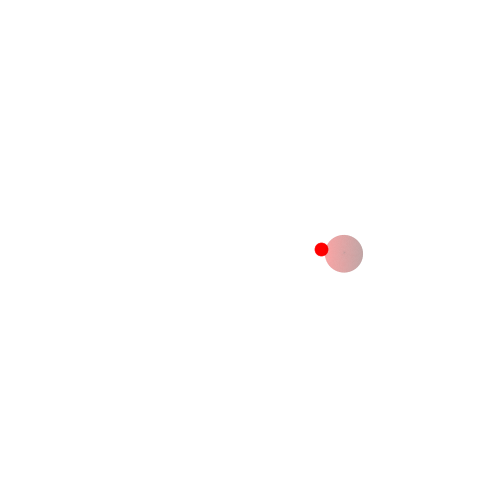

In [3]:
env = DroneEnv(num_agents=1, SIZE=(4,4), PROB=(0,0.))
env.world.agents[0][:2] = [0.5, 0.5]
env.world.agent_goals[0][:2] = [3, 3]
gifs = [env._render()]
while not env.finished:
    a_all = np.random.uniform(-1, 1, size=(1, 2000, env.action_dim))
    dists = env.potential_field(a_all, K1=100, K2=-3e-2)
    env.step(a_all[:, np.argmin(dists[0])])
    print(env._get_obs()['toward'].edge_attr.norm())
    gifs.append(env._render())
    
from core import save_gif
save_gif(gifs, 'gifs/0405/lol.gif')

In [7]:
env._get_obs()['agent'].pos

tensor([[ 2.5906,  2.8542,  5.9379,  0.6181,  0.3219, -0.0737, -0.3650,  0.2113,
          0.0823]])

In [ ]:
from tqdm import tqdm
from collections import defaultdict

Env = DroneEnv
env = DroneEnv(num_agents=1, SIZE=(4,4), PROB=(0,0.))

lnn = DMLP(state_dim=env.state_dim, action_dim=env.action_dim, piembed=128, mode='sum')
lnn.to(device)
lnn.train()

name_dict = generate_default_model_name(Env)

loptimizer = torch.optim.Adam(lnn.parameters(), lr=1e-3, weight_decay=1e-8)
lscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(loptimizer, factor=0.5, patience=2)

max_episode_length = 256

BATCH = 32
N_ITER = 40
N_EPOCH = 12000
N_TRAJ = 1000
N_TRAJ_PER_EPOCH = 20
N_BUFFER = 20
N_EVALUATE = 20

threshold=1e-2
running_displace_rate = 0
best_displace_rate = float('inf')
dispace_rates = [1.]*N_EVALUATE
nominal_eps = 1.0
explore_eps = 0.1

LMODEL_PATH = name_dict['dl'].replace('dlgnn', 'dlnn')
open('1model_'+Env.__name__+'.txt', 'w+').close()
lbuf_gather = GatherReplayBuffer(BATCH)

pbar = tqdm(range(N_TRAJ))
for epoch_i in pbar:
    
    lbuf = GlobalReplayBuffer()

    env = DroneEnv(num_agents=1, SIZE=(4,4), PROB=(0,0.))
    env.world.agents[0][:2] = [0.5, 0.5]
    env.world.agent_goals[0][:2] = np.array([3, 3])+0.01*np.random.rand()
    total_trans=0; n_danger=0; threshold=-1e-2; no_feasible=0; collided=False

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))

        o = {'x': o['toward']['edge_attr'][0, :]}
        a_refine, lvalue = iter_action(lnn, o, a_all, max_iter=0, threshold=threshold)  # min(epoch_i//10, 30)
        
        dists = env.potential_field(a_refine.reshape(1, -1, env.action_dim), K1=100, K2=-3e-2)
        # print(lvalue.max(), lvalue.min(), lvalue[np.argmin(dists)])
        if epoch_i < 10:  # warmup
            a = a_refine[np.argmin(dists)]
        elif np.random.rand() >= explore_eps:
            a = a_refine[np.argmin(lvalue)]
        else:
            a = a_refine[np.random.randint(len(lvalue))]

        next_o, rw, done, info = env.step(np.array([a]))
        info['dist2goal'] = info['toward'].edge_attr[:,-env.space_dim:].norm()
        lbuf.store(info)
        prev_danger = info['prev_danger']
        next_danger = info['next_danger']
        if next_danger:
            collided = True

        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length) or (np.abs(env.world.agents[0,:]).max()>7):
            lbuf_old = GlobalReplayBuffer()
            for obs in lbuf.obs_buf:
                lbuf_old.obs_buf.append(obs.clone())
            lbuf_gather.append(lbuf_old)
            lbuf.relabel(env.space_dim, env.goal_threshold)
            lbuf_gather.append(lbuf)
            break

    dispace_rates.append(min([float(info['dist2goal']) for info in lbuf.obs_buf]))
    running_displace_rate = np.mean(dispace_rates)
    if running_displace_rate < best_displace_rate:
        best_displace_rate = running_displace_rate
        torch.save(lnn.state_dict(), LMODEL_PATH)

    if len(dispace_rates) > N_EVALUATE:
        dispace_rates.pop(0)

    if (epoch_i % N_TRAJ_PER_EPOCH) == (N_TRAJ_PER_EPOCH-1):
        lnn.train()
        train_lya(lnn, loptimizer, lbuf_gather, pbar=pbar, n_iter=N_ITER)
        torch.save(lnn.state_dict(), LMODEL_PATH.replace('.pt', '_current.pt'))
        if epoch_i // N_TRAJ_PER_EPOCH != 0:
            lscheduler.step(running_displace_rate)
        # explore_eps = max(0.1, explore_eps * 0.8)
        lbuf_gather = GatherReplayBuffer(BATCH)

    with open('1model_'+Env.__name__+'.txt', 'a+') as f:
        f.write(pbar.desc+'\t'+str(epoch_i)+'\t'+'displace: {0:.6f}'.format(dispace_rates[-1])+' running rate: {0:.6f}'.format(running_displace_rate)+', buf size {0:d}, '.format(len(lbuf.obs_buf))+str(lbuf.obs_buf[-1]['goal'].pos[:,:env.space_dim])+'\n')

iter #12, gloss 0.000000, dloss 0.000000:  74%|███████▍  | 739/1000 [2:15:01<21:31,  4.95s/it]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

iter #24, gloss 0.000000, dloss 0.000022:  84%|████████▍ | 839/1000 [2:32:38<12:34,  4.68s/it]  IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

iter #13, gloss 0.000002, dloss 0.000009:  86%|████████▌ | 859/1000 [2:35:39<10:25,  4.43s/it]

In [11]:
loptimizer.param_groups[0]['lr']

6.103515625e-07

In [4]:
lbuf

In [6]:
%debug

> /home/rainorangelemon/Documents/CAM/train_lya_drone.py(139)relabel()
    137             if obs['next_goal'].any():
    138                 break
--> 139         self.obs_buf = self.obs_buf[:(idx+1)]
    140 
    141 



ipdb>  idx


252


ipdb>  exit()


In [5]:
lbuf.obs_buf[-1]

HeteroData(
  action=[1, 4],
  prev_free=[1],
  prev_danger=[1],
  next_goal=[1],
  next_free=[1],
  next_danger=[1],
  meet_obstacle=[1],
  meet_agent=[1],
  dist2goal=4.794336318969727,
  agent={
    x=[1, 1],
    pos=[1, 9]
  },
  obstacle={ x=[1, 1] },
  goal={
    x=[1, 1],
    pos=[1, 9]
  },
  (agent, a_near_a, agent)={
    edge_index=[2, 0],
    edge_attr=[0, 15]
  },
  (goal, toward, agent)={
    edge_index=[2, 1],
    edge_attr=[1, 9]
  }
)

In [5]:
%debug

> /home/rainorangelemon/Documents/CAM/train_lya_drone.py(39)compute_loss()
     37     # Set up function for computing value loss
     38     def compute_loss(lnn, data, next_data):
---> 39         value = lnn(**data)
     40         next_value = lnn(**next_data)
     41 



ipdb>  data


HeteroDataBatch(
  action=[512, 4],
  prev_free=[512],
  prev_danger=[512],
  next_goal=[512],
  next_free=[512],
  next_danger=[512],
  meet_obstacle=[512],
  meet_agent=[512],
  dist2goal=[512],
  agent={
    x=[512, 1],
    batch=[512],
    ptr=[513]
  },
  obstacle={
    x=[512, 1],
    batch=[512],
    ptr=[513]
  },
  goal={
    x=[512, 1],
    batch=[512],
    ptr=[513]
  },
  (agent, a_near_a, agent)={
    edge_index=[2, 0],
    edge_attr=[0, 15]
  },
  (goal, toward, agent)={
    edge_index=[2, 512],
    edge_attr=[512, 9]
  }
)


ipdb>  exit()


In [232]:
n_d = 0
for d in cbuf.obs_buf:
    if not d['prev_danger']:
        n_d += 1
        print('--------------------------------')
        print(d['x'], d['action'], lnn(x=d['x'].to(device), action=d['action'].to(device)))
        for _ in range(10):
            a = torch.FloatTensor(2).uniform_(-1, 1)
            print(lnn(x=d['x'].to(device), action=a.to(device)))
print(n_d)

--------------------------------
tensor([-1.1000,  0.0000]) tensor([1., 0.]) tensor(-0.1272, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0336, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.1101, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0165, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.0260, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0482, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.1037, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0543, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0391, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0316, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(-0.0949, device='cuda:0', grad_fn=<SqueezeBackward1>)
--------------------------------
tensor([-1.1000, -0.4599]) tensor([1.0000, 0.4599]) tensor(-0.0657, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0649, device='cuda:0', grad_fn=<SqueezeBackward1>)
tensor(0.0488, device='cuda:0', grad_fn=<SqueezeBack

In [451]:
lnn(x=cbuf.obs_buf[0]['x'].to(device), action=cbuf.obs_buf[0]['action'].to(device))

tensor(-0.1215, device='cuda:0', grad_fn=<SqueezeBackward1>)

In [415]:
cbuf.obs_buf[0]['action'].to(device)

tensor([-0.8627, -1.0000], device='cuda:0')

In [434]:
torch.rand(2).uniform_(-1, 1)

tensor([-0.5567,  0.0523])

## check on existing data

In [55]:
total_buffer = []
total_buffer_a = []
total_buffer_d = []
total_buffer.extend([o['x'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])
total_buffer_a.extend([o['action'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])
total_buffer_d.extend([o['next_danger'].data.cpu().numpy() for b in bbuf_gather.buffers for o in b.obs_buf])

In [ ]:
total_buffer

In [453]:
len(total_buffer)

32830

In [454]:
len(cbuf.obs_buf)

103

In [392]:
total_buffer = np.array(total_buffer)
total_buffer_a = np.array(total_buffer_a)

In [ ]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(total_buffer)
dists, idxs = nbrs.kneighbors(total_buffer, 10, return_distance=True)
best_idx = dists.mean(axis=-1).argmin()
random_data = total_buffer[best_idx]
dists, idxs = nbrs.kneighbors([random_data], 10, return_distance=True)
total_buffer_a[idxs], dists

# inference

In [ ]:
from gym_point import PointEnv
from stable_baselines3 import PPO
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Env = PointEnv
env = PointEnv()
nominal_control = lambda x: np.clip(np.array([2, 0])-x, -1, 1)
name_dict = generate_default_model_name(Env)

lnn = DMLP(state_dim=Env.state_dim, action_dim=Env.action_dim, mode='straight')
BMODEL_PATH = name_dict['dl'].replace('dlgnn', 'dlnn').replace('.pt', '_current.pt')
lnn.load_state_dict(torch.load(BMODEL_PATH, map_location=device))
lnn.to(device)
lnn.eval()

writer = SummaryWriter()
writer.step = 0
max_episode_length = 256
BATCH = 64
N_ITER = 1
N_EPOCH = 12000

### visualization on traj

  0%|          | 0/1000 [00:00<?, ?it/s]

0.51668584 0.45568436 0.4753323
0.5121472 0.45598882 0.48237738
0.5182724 0.45832708 0.4894686
0.51170623 0.46194443 0.49453893
0.5186333 0.46636555 0.49865294
0.53281546 0.47081798 0.50070345
0.53669435 0.47649354 0.510224
0.54387605 0.47988358 0.5127435
0.53675485 0.48114324 0.5124332
0.538844 0.48357147 0.5161058
0.544093 0.4862392 0.5169448
0.53978086 0.487385 0.5169612
0.54751164 0.48845792 0.5216947
0.54790354 0.48838857 0.5255539
0.5538924 0.48943818 0.5258354
0.55187154 0.49180415 0.52474403
0.5492523 0.4922703 0.5311743
0.5580813 0.49339828 0.5247438
0.5630181 0.49441755 0.5331471
0.5570991 0.49654102 0.5336556
0.5668818 0.49907464 0.53000337
0.56094915 0.5024538 0.53160155
0.5712031 0.5049979 0.53997904
0.57068443 0.50872934 0.5421025
0.5796457 0.51234066 0.54786193
0.58442247 0.51678896 0.55358243
0.58391243 0.5211724 0.55535364
0.58625036 0.52454823 0.55253136
0.59740824 0.528214 0.5563973
0.6024603 0.5342494 0.5656232
0.60735303 0.5376517 0.5783881
0.6151024 0.539155 0.576

  0%|          | 0/1000 [00:13<?, ?it/s]


AssertionError: 

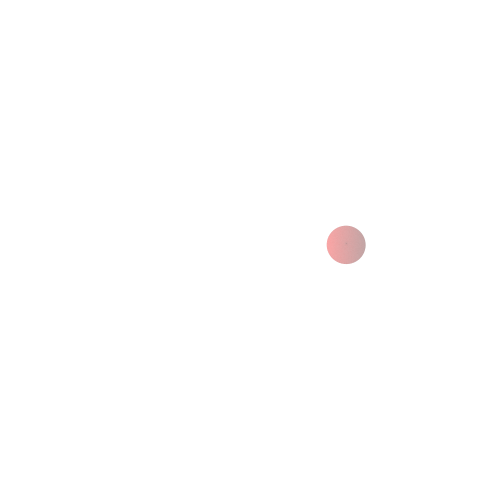

In [13]:
from tqdm import tqdm
from collections import defaultdict

Env = DroneEnv
env = DroneEnv(num_agents=1, SIZE=(4,4), PROB=(0,0.))

lnn = DMLP(state_dim=env.state_dim, action_dim=env.action_dim, piembed=256, mode='sum')
lnn.to(device)
lnn.train()

name_dict = generate_default_model_name(Env)

loptimizer = torch.optim.Adam(lnn.parameters(), lr=3e-4, weight_decay=1e-8)
lscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(loptimizer, factor=0.5, patience=2)

max_episode_length = 256

BATCH = 32
N_ITER = 100
N_EPOCH = 12000
N_TRAJ = 1000
N_TRAJ_PER_EPOCH = 10
N_BUFFER = 100
N_EVALUATE = 100

threshold=1e-2
running_displace_rate = 0
best_displace_rate = float('inf')
dispace_rates = [1.]*N_EVALUATE
nominal_eps = 1.0
explore_eps = 0.1

LMODEL_PATH = name_dict['dl'].replace('dlgnn', 'dlnn')
open('1model_'+Env.__name__+'.txt', 'w+').close()
lbuf_gather = GatherReplayBuffer(BATCH)
fbuf = GlobalReplayBuffer()

pbar = tqdm(range(N_TRAJ))
for epoch_i in pbar:
    
    lbuf = GlobalReplayBuffer()

    env = DroneEnv(num_agents=1, SIZE=(4,4), PROB=(0,0.))
    env.world.agents[0][:2] = [0.5, 0.5]
    env.world.agent_goals[0][:2] = np.array([3, 3])+0.01*np.random.rand()
    total_trans=0; n_danger=0; threshold=-1e-2; no_feasible=0; collided=False
    
    gifs = [env._render()]

    while True:
        o = env._get_obs()
        a_all = np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))

        o = {'x': o['toward']['edge_attr'][0, :]}
        a_refine, lvalue = iter_action(lnn, o, a_all, max_iter=0, threshold=threshold)  # min(epoch_i//10, 30)
        
        dists = env.potential_field(a_refine.reshape(1, -1, env.action_dim), K1=100, K2=-3e-2)
        print(lvalue.max(), lvalue.min(), lvalue[np.argmin(dists)])
        a = a_refine[np.argmin(lvalue)]

        next_o, rw, done, info = env.step(np.array([a]))
        gifs.append(env._render())
        
        info['dist2goal'] = info['toward'].edge_attr.norm()
        lbuf.store(info)
        prev_danger = info['prev_danger']
        next_danger = info['next_danger']
        if next_danger:
            collided = True

        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length) or (np.abs(env.world.agents[0,:]).max()>7):
            lbuf.relabel(env.space_dim, env.goal_threshold)
            lbuf_gather.append(lbuf)
            from core import save_gif
            save_gif(gifs, 'gifs/0406/lol.gif')
            assert False
            break

#     dispace_rates.append(min([float(info['dist2goal']) for info in lbuf.obs_buf]))
#     running_displace_rate = np.mean(dispace_rates)
#     if running_displace_rate < best_displace_rate:
#         best_displace_rate = running_displace_rate
#         torch.save(lnn.state_dict(), LMODEL_PATH)

#     if len(lbuf_gather.buffers) > N_BUFFER:
#         lbuf_gather.buffers.pop(0)
#     if len(dispace_rates) > N_EVALUATE:
#         dispace_rates.pop(0)

#     if (epoch_i % N_TRAJ_PER_EPOCH) == (N_TRAJ_PER_EPOCH-1):
#         lnn.train()
#         train_lya(lnn, loptimizer, lbuf_gather, pbar=pbar, n_iter=100)
#         torch.save(lnn.state_dict(), LMODEL_PATH.replace('.pt', '_current.pt'))
#         explore_eps = max(0.01, explore_eps * 0.8)

#     with open('1model_'+Env.__name__+'.txt', 'a+') as f:
#         f.write(pbar.desc+'\t'+str(epoch_i)+'\t'+'displace: {0:.6f}'.format(dispace_rates[-1])+' running rate: {0:.6f}'.format(running_displace_rate)+', buf size {0:d}, '.format(len(lbuf.obs_buf))+str(lbuf.obs_buf[-1]['goal'].pos)+'\n')

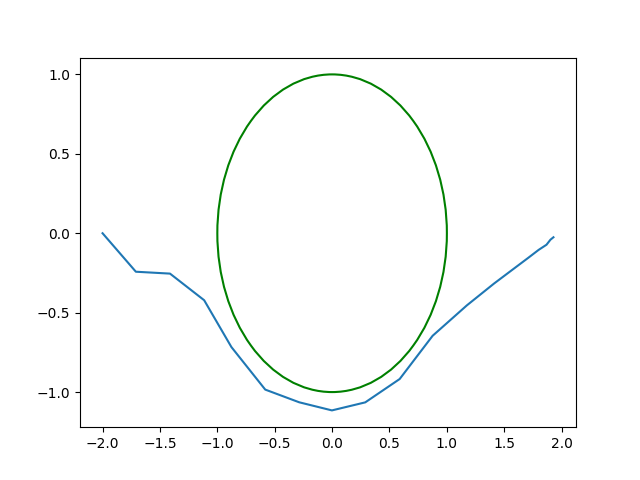

In [118]:
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(infer_traj).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()

### visualization on CBF

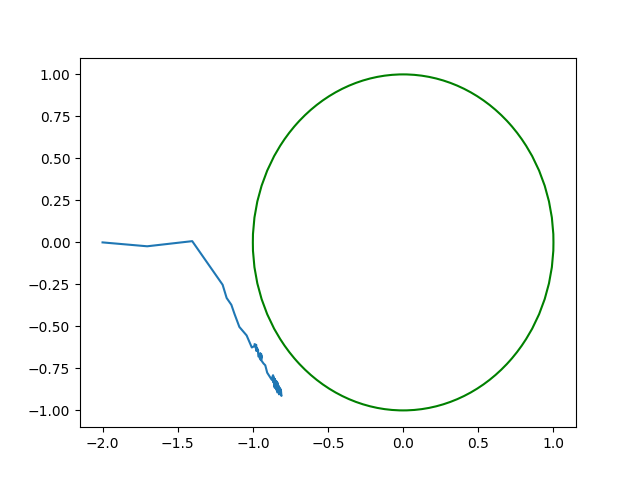

In [129]:
%matplotlib widget
import ipympl
import matplotlib.pyplot as plt
plt.clf()
plt.close('all')
fig, ax = plt.subplots()
plt.plot(*np.array(trajs[30]).T)
c = plt.Circle((0, 0), 1, edgecolor='g', facecolor='white', clip_on=False, linewidth=1.5)
ax.add_patch(c)
plt.show()

In [59]:
lnn(x=torch.FloatTensor(np.array(trajs[99])[:-1]).to(device), action=torch.FloatTensor(np.array(trajs[99])[1:,]-np.array(trajs[99])[:-1]).to(device)/0.3).data.cpu().numpy()

array([ 0.00615322,  0.0168369 ,  0.02461939,  0.03725697, -0.04950445,
        0.04675311, -0.01833821,  0.03422268,  0.08368017,  0.09180238,
        0.20361288,  0.3725643 ,  0.5286677 ,  0.6686999 ,  0.7717982 ,
        0.8585829 ,  0.907426  ,  0.94885206,  0.979881  ], dtype=float32)

In [42]:
trajs[59][1]

array([-1.73082578, -0.24192397])

In [133]:
lnn(x=torch.FloatTensor([-1.1, 0]).to(device), action=torch.FloatTensor([0.4, 0]).to(device))

tensor(0.0157, device='cuda:0', grad_fn=<SqueezeBackward1>)

### G

In [37]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 1000
env.reset()
#     env.world.agents = env.world.sample_agents(env.num_agents, prob=0.0)
total_trans=0; n_danger=0; threshold=1e-2

while True:
    o = env._get_obs()
    a_best = nominal_control(o)
    a_other = np.random.uniform(-1., 1., size=(n_candidates-1, env.action_dim))
    a_all = np.zeros((n_candidates, env.action_dim))
    a_all[0, :] = a_best
    a_all[1:, :] = a_other

    o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
    a_refine, bvalue = iter_action(lnn, o, a_other, max_iter=0, threshold=threshold)

    a, a_value = choose_action(a_refine, bvalue, threshold=threshold, explore_eps=0., nominal_eps=0.)

    next_o, rw, done, info = env.step(a_best)
    # if info['next_danger']:
    print(o['x'], a_value)
    n_collide += info['next_danger']

    threshold = 1e-2
    total_trans += 1
    n_danger += np.array(next_danger).sum()

    if done or (total_trans >= max_episode_length):
        n_reach += info['next_goal']
        break

tensor([-2.,  0.]) -0.13107894
tensor([-1.7000,  0.0000]) -0.122936025
tensor([-1.4000,  0.0000]) -0.11164804
tensor([-1.1000,  0.0000]) -0.10055794
tensor([-0.8000,  0.0000]) -0.09046771
tensor([-0.5000,  0.0000]) -0.082239956
tensor([-0.2000,  0.0000]) -0.0731955
tensor([0.1000, 0.0000]) -0.06821193
tensor([0.4000, 0.0000]) -0.07327388
tensor([0.7000, 0.0000]) -0.06384854
tensor([1., 0.]) -0.07175657
tensor([1.3000, 0.0000]) -0.08446115
tensor([1.5100, 0.0000]) -0.08590387
tensor([1.6570, 0.0000]) -0.079477355
tensor([1.7599, 0.0000]) -0.095163316
tensor([1.8319, 0.0000]) -0.08545959
tensor([1.8824, 0.0000]) -0.08211541


# benchmark

In [102]:
n_collide = 0
n_reach = 0
threshold = 1000
N_TEST = 100

for _ in tqdm(range(N_TEST)):
    
    infer_traj = [env.reset()]
    total_trans=0; n_danger=0; threshold=5e-2; collided=False
    env.state = env.state + np.random.uniform(-5e-2, 5e-2, size=(2,))

    while True:
        o = env._get_obs()
        a_all = np.hstack([i.reshape(-1, 1) for i in np.meshgrid(*([np.linspace(-1, 1, 20)]*2))])  #np.random.uniform(-1, 1, size=(n_candidates, env.action_dim))

        o = {'x': torch.FloatTensor(o), 'goal': torch.FloatTensor(env.goal)}
        a_refine, bvalue = iter_action(lnn, o, a_all, max_iter=0, threshold=threshold)

        dists = []
        for a in a_refine:
            next_state = a + env.state
            dists.append(np.linalg.norm(next_state-np.array([2, 0])))
        if np.any(bvalue>threshold):
            for a_idx in np.argsort(dists):
                if bvalue[a_idx] > threshold:
                    a = a_refine[a_idx]
                    break
        else:
            a = a_refine[np.argmax(bvalue)]

        next_o, rw, done, info = env.step(a)
        infer_traj.append(env.state.copy())
        # if info['next_danger']:
        # print(bvalue[0], bvalue.min(), bvalue.max(), threshold, a_value, 'TRUE' if info['next_danger'] else '')
        if info['next_danger']:
            collided = True
        
        total_trans += 1
        n_danger += np.array(next_danger).sum()

        if done or (total_trans >= max_episode_length):
            n_collide += collided
            n_reach += info['next_goal']
            break

100%|██████████| 100/100 [00:06<00:00, 14.72it/s]


In [103]:
n_collide

0

In [104]:
n_reach

100